In [13]:
! pip install --q blingfire spacy transformers sentence-transformers umap-learn hdbscan stop-words

     |████████████████████████████████| 28.3MB 1.5MB/s 


In [199]:
import re
import itertools
import collections

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

from tqdm.autonotebook import tqdm

In [285]:
pd.set_option('display.max_colwidth', 300)
pd.set_option('display.float_format', '{:,.2f}'.format)
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [70]:
def printmd(string):
    display(Markdown(string))

In [252]:
TAB = '&nbsp;&nbsp;&nbsp;&nbsp;'
BULLET = f'{TAB}➡'

# Topic Discovery

## Prepare Input Text Data

In [198]:
from sklearn.datasets import fetch_20newsgroups
from blingfire import text_to_sentences

In [5]:
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, stem_text, strip_punctuation, remove_stopwords
from gensim.parsing import preprocess_string

In [6]:
data = fetch_20newsgroups(subset='all')['data']

In [19]:
fetch_20newsgroups(subset='all').keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [20]:
fetch_20newsgroups(subset='all')['filenames']

array(['/root/scikit_learn_data/20news_home/20news-bydate-test/rec.sport.hockey/54367',
       '/root/scikit_learn_data/20news_home/20news-bydate-train/comp.sys.ibm.pc.hardware/60215',
       '/root/scikit_learn_data/20news_home/20news-bydate-train/talk.politics.mideast/76120',
       ...,
       '/root/scikit_learn_data/20news_home/20news-bydate-train/comp.sys.ibm.pc.hardware/60695',
       '/root/scikit_learn_data/20news_home/20news-bydate-train/comp.graphics/38319',
       '/root/scikit_learn_data/20news_home/20news-bydate-test/rec.autos/103195'],
      dtype='<U86')

In [28]:
sentence_items = []
for i, document in enumerate(data):
  document_sentences = text_to_sentences(document).split("\n")
  sentence_with_idx = itertools.zip_longest(document_sentences, [i], fillvalue=i)
  sentence_items.extend(sentence_with_idx)

In [30]:
sentence_items[1000]

('The Air Force, of course, was interested in our results and supportive of our efforts.',
 75)

In [36]:
df_sentences = pd.DataFrame(sentence_items, columns=['original_sentence', 'document_id'])

In [37]:
df_sentences.sample(n=3)

,original_sentence,document_id
130363,"From: jaeger@buphy.bu.edu (Gregg Jaeger) Subject: Re: The Inimitable Rushdie Organization: Boston University Physics Department Lines: 32 In article <1993Apr10.130112.25440@bradford.ac.uk> L.Newnham@bradford.ac.uk (Leonard Newnham) writes: >Gregg Jaeger (jaeger@buphy.bu.edu) wrote: >>>And no,...",9603
28692,"I think both are overrated defensively (see Nichols' Law of catcher defense), but that's something that's difficult to prove or disprove from your viewpoint or mine.",2210
168098,Information is hard to prove.,12230


In [35]:
transform_to_lower = lambda s: s.lower()

remove_single_char = lambda s: re.sub(r'\s+\w{1}\s+', '', s)

# Filters to be executed in pipeline
CLEAN_FILTERS = [strip_tags,
                strip_numeric,
                strip_punctuation, 
                strip_multiple_whitespaces, 
                transform_to_lower,
                remove_stopwords,
                remove_single_char]
# Method does the filtering of all the unrelevant text elements
def cleaning_pipe(document):
    # Invoking gensim.parsing.preprocess_string method with set of filters
    processed_words = preprocess_string(document, CLEAN_FILTERS)
    
    return ' '.join(processed_words)

In [47]:
df_sentences['sentence'] = df_sentences['original_sentence'].progress_apply(cleaning_pipe)

In [234]:
sample_idx = 200
printmd('**Data Cleaning**')
original_sentence, sentence = df_sentences.iloc[sample_idx][['original_sentence', 'sentence']]
print(f'  Raw text: {original_sentence}')
print(f'  Cleaned: {sentence}')

**Data Cleaning**

  Raw text: It seems at both ends of his envisioned  pan-Turkic Empire -- the Balkans and the Caucasus -- Turkey's fascist boasts are being pre-empted.
  Cleaned: ends envisioned pan turkic empire balkans caucasus turkeyfascist boasts pre empted


In [61]:
 df_sentences.drop_duplicates(subset='sentence', inplace=True)
 df_sentences.shape

(204571, 3)

In [53]:
df_sentences.head()

,original_sentence,document_id,sentence
0,"From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu> Subject: Pens fans reactions Organization: Post Office, Carnegie Mellon, Pittsburgh, PA Lines: 12 NNTP-Posting-Host: po4.andrew.cmu.edu I am sure some bashers of Pens fans are pretty confused about the lack of any kind of posts about the re...",0,mamatha devineni ratnam subject pens fans reactions organization post office carnegie mellon pittsburgh pa lines nntp posting host po andrew cmu edu sure bashers pens fans pretty confused lack kind posts recent pens massacre devils
1,"Actually, I am bit puzzled too and a bit relieved.",0,actually bit puzzled bit relieved
2,"However, I am going to put an end to non-PIttsburghers' relief with a bit of praise for the Pens.",0,going end non pittsburghers relief bit praise pens
3,"Man, they are killing those Devils worse than I thought.",0,man killing devils worse thought
4,Jagr just showed you why he is much better than his regular season stats.,0,jagr showed better regular season stats


In [235]:
printmd(f'**Sentences count**: {df_sentences.shape[0]:,}.')

**Sentences count**: 204,571.

## Step 1 - Sentence Representation

In [62]:
from sentence_transformers import SentenceTransformer

In [65]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings_sbert = model.encode(df_sentences['sentence'].values, show_progress_bar=True)

In [85]:
sbert_embeddings_count, sbert_embeddings_size = embeddings_sbert.shape
printmd(f'**Sentence-BERT embeddings**: {sbert_embeddings_count:,} vectors of size {sbert_embeddings_size}.')

**Sentence-BERT embeddings**: 204,571 vectors of size 768.

## Step 2 - Dimensionality Reduction

In [80]:
import umap

In [82]:
embeddings_reduced = umap.UMAP(
    n_neighbors=15, 
    n_components=5, 
    metric='cosine'
).fit_transform(sbert_embeddings)

In [86]:
embeddings_2d = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.0,
    metric='cosine'
).fit_transform(sbert_embeddings)

## Step 3 - Clustering

In [94]:
import hdbscan

In [96]:
cluster = hdbscan.HDBSCAN(
    min_cluster_size=10,
    metric='euclidean',                      
    cluster_selection_method='eom').fit(embeddings_reduced)

In [98]:
df_sentences['cluster_id'] = cluster.labels_

In [101]:
df_sentences_clustered = df_sentences[df_sentences['cluster_id'] != -1]

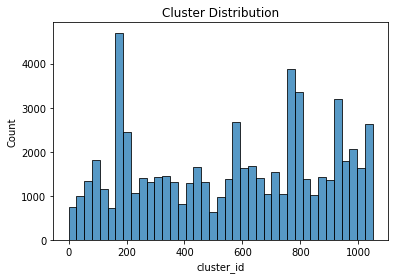

In [106]:
sns.histplot(df_sentences_clustered['cluster_id'], palette='Paired')
plt.title('Cluster Distribution');

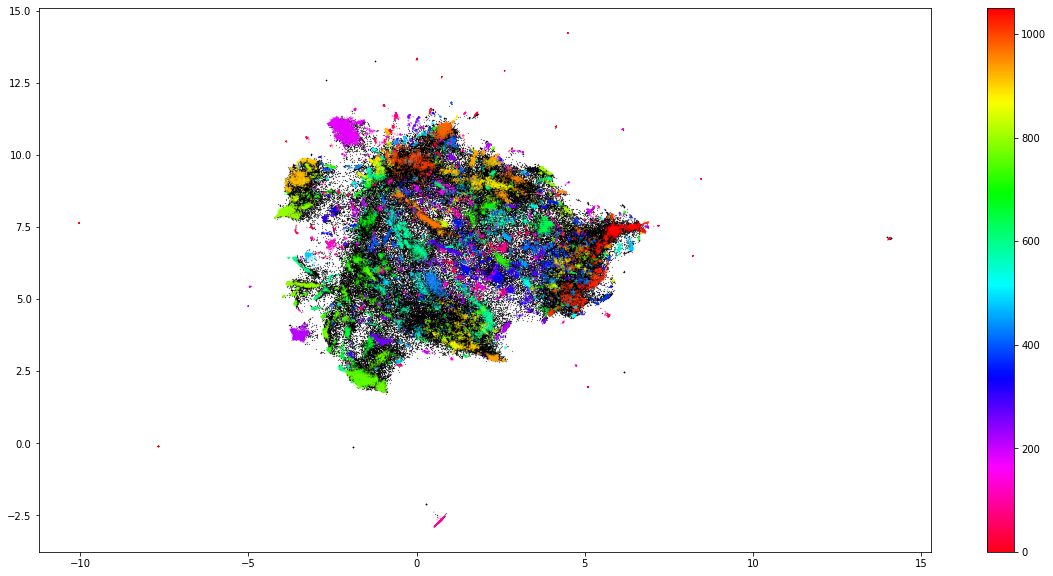

In [111]:
# Prepare data
result = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='black', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [ ]:
df_sentences_per_cluster = df_sentences.groupby(['cluster_id'], as_index = False).agg({'sentence': ' '.join})

In [140]:
df_sentences.loc[df_sentences['cluster_id'].isin([800])][:3]

,original_sentence,document_id,sentence,cluster_id
3815,"Organization: Allegheny College In article <C5Jsxs.1M0@unix.amherst.edu> jlroffma@unix.amherst.edu (JOSHUA LAWRENCE ROFFMAN) writes: > : >baseball players, past and present.",325,organization allegheny college article jlroffma unix amherst edu joshua lawrence roffman writes baseball players past present,800
6330,"From: hamkins@geisel.csl.uiuc.edu (Jon Hamkins) Subject: Re: Triva question on Bosio's No-hitter Organization: Center for Reliable and High-Performance Computing, University of Illinois at Urbana-Champaign Lines: 16 NNTP-Posting-Host: grinch.csl.uiuc.edu wall@cc.swarthmore.edu (Matthew Wall) wr...",529,hamkins geisel csl uiuc edu jon hamkins subject triva question bosiohitter organization center reliable high performance computing university illinois urbana champaign lines nntp posting host grinch csl uiuc edu wall cc swarthmore edu matthew wall writesactually answer bosio walking batters reti...,800
6869,"From: tedward@cs.cornell.edu (Edward [Ted] Fischer) Subject: Re: Bases loaded walk gives Reds win in 12 Organization: Cornell Univ. CS Dept, Ithaca NY 14853 Lines: 87 In article <mssC5y5u0.4Dn@netcom.com> mss@netcom.com (Mark Singer) writes: > >Actually, I think the large-scale sample size is p...",576,tedward cs cornell edu edward ted fischer subject bases loaded walk gives reds win organization cornell univ cs dept ithaca ny lines article mss netcom com mark singer writes actually think large scale sample size problem plot players baseball regard ba vs clutch ba deviation kind bell curve,800


# Step 4 - Topic Summarization

In [203]:
import spacy

In [236]:
nlp = spacy.load("en_core_web_sm")

In [147]:
df_sentences_per_cluster = df_sentences\
  .groupby(['cluster_id'], as_index = False)\
  .agg({'sentence': ' '.join})\
  .rename(columns={'sentence': 'cluster_sentences'})

In [163]:
df_sentences_per_cluster.sample(n=10)

,cluster_id,cluster_sentences
179,178,sole intention learning fly prb access digex com pat subject conference manned lunar exploration crystal city organization express access online communications greenbelt md usa lines distribution na nntp posting host access digex net aw st brief blurb manned lunar exploration confernce th crysta...
849,848,organization case western reserve university cleveland oh usa lines reply ch cleveland freenet edu tony alicea nntp posting host hela ins cwru edu previous article cdcolvin rahul net christophercolvin says worked amorc hs bj cleveland freenet edu mikeromano subject drop drawers doctor organizati...
3,2,wd cs tu berlin wolfgang diestelkamp subject universal phones days tony morgan demon uk tony kidson subject universal phones days thomas tornblom nexus comm se thomas tornblom subject universal phones days jtsilla damon ccs northeastern edu james tsillas subject universal phones days lhe sics se...
453,452,scott hiles whiles relay nswc navy mil standard disclaimer opinions expressed necessarily reflect dod navy thanks keith keith radio nl nuwc navy mil pugsley dpugsle nswc wo nswc navy mil pmontan nswc wo navy mil paul montanaro subject iiciupgrade mark cervi carderockdiv nswc code annapolis md ce...
758,757,hapenned tragedy war crime irgun harry agree harry concede arab terrorism tragedy war remember palestinians effective target civilians order cause notice israel talks acts tough battle willing talk peace way israelis arabs able achieve peace years fighting following major reasons arab government...
152,151,jean andrews subject wanted large dog cage organization graduate school industrial administr carnegie mellon pittsburgh pa lines nntp posting host po andrew cmu edu need large dog cage kind use housebreak dog dave svoboda svoboda void rtsg mot comgetting tired concours mmmmmmmmmm beating dave rz...
467,466,clipper organization dec systems research center lines article brad clarinet com brad templeton writes actual algorithm classified main thrust cellular phones encryption radio end end end think wonderful encrypter borrow converts message meet bomb white house rboudrie chpc org rob boudrie subjec...
791,790,ll post newsgroups font available replymail office days reading news crossposting crossposting occurs newsgroup included newsgroups line article header articles appear newsgroups listed distribution field header news article allows partially control article goes called distribution field distrib...
731,730,holds meaning survived correction fbi said cult members said far able talk fbi chasing pinkos general publicmind bit extra constitutional activity prior initial assault complex single batf agent accompanying witness contingent assault news media personnel attempt knock door branch davidiancomple...
406,405,institute named catoletters libertarian pamphlets widely read american colonies early th century played major role laying philosophical foundation american revolution republican dirty tricksters people expect texans congressmen actj republicans stephanopoulos house republicans voted q president ...


In [149]:
from sklearn.feature_extraction.text import CountVectorizer

In [159]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, labels, n=20):
    words = count.get_feature_names()
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['cluster_id'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [156]:
tf_idf, count = c_tf_idf(df_sentences_per_cluster['cluster_sentences'].values, m=df_sentences.shape[0])

In [157]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, df_sentences_per_cluster['cluster_id'].tolist(), n=20)

In [164]:
topic_sizes = extract_topic_sizes(df_sentences_per_cluster['cluster_id']); topic_sizes.head(10)

KeyError: ignored

In [173]:
top_n_words[900]

[('fail', 0.5511826034457368),
 ('deaf', 0.46287806199936876),
 ('thwarted', 0.26708496949456095),
 ('unsuccessful', 0.25430844802662145),
 ('greasy', 0.25430844802662145),
 ('dimension', 0.22979375844754402),
 ('shouted', 0.22539759832482914),
 ('clothes', 0.21406120579608034),
 ('adds', 0.20584081934760262),
 ('analogy', 0.20035657541136562),
 ('discrimination', 0.1971703140547015),
 ('phrase', 0.19047994199195833),
 ('efforts', 0.18891616776904252),
 ('fails', 0.18841489948034001),
 ('blind', 0.18650017963080245),
 ('motor', 0.18386640440561872),
 ('remain', 0.1802308691824393),
 ('purposes', 0.17747035392059204),
 ('failed', 0.17409321779171272),
 ('stick', 0.17361733159609966)]

In [183]:
df_sentences.reset_index(inplace=True)

In [176]:
! curl --silent -O https://raw.githubusercontent.com/UKPLab/sentence-transformers/master/examples/applications/text-summarization/LexRank.py

In [184]:
from sentence_transformers.util import pytorch_cos_sim
from LexRank import degree_centrality_scores

examples_by_cluster = {}
cluster_iter = tqdm(df_sentences.groupby("cluster_id"), desc="Clusters")
for cluster_id, cluster_group in cluster_iter:
    if cluster_id == -1:
      continue
    cluster_emb = np.take(embeddings_sbert, cluster_group.index.values, axis=0)
    cos_scores = pytorch_cos_sim(cluster_emb, cluster_emb).numpy()
    centrality_scores = degree_centrality_scores(cos_scores, threshold=None)
    cluster_examples = cluster_group.iloc[np.argsort(-centrality_scores)[:10]]
    examples_by_cluster[cluster_id] = cluster_examples.sentence.values.tolist()

In [192]:
df_sentences_per_cluster["central_sentences"] = df_sentences_per_cluster["cluster_id"].apply(examples_by_cluster.get)

In [196]:
df_sentences_per_cluster.sample(n=5)

,cluster_id,cluster_sentences,central_sentences
602,601,beck irzr inf tu dresden andre beck subject drawing colour pixmaps rectangular organization dept science tu dresden germany organization dept science tu dresden germany beck irzr inf tu dresden andre beck subject encapsulated postscriptkeywords eps reply andre beck irs inf tu dresden organizatio...,"[beck irzr inf tu dresden andre beck subject file tmp organization dept science tu dresden germany, beck irzr inf tu dresden andre beck subject cuteclients organization dept science tu dresden germany, beck irzr inf tu dresden andre beck subject pov problems tga outputs organization dept science..."
971,970,robink hparc aus hp com robin kenny subject boom mbeaving bnr ca michael beavington subject boom rwalls twg com roger walls subject boom gharriso hpcc corp hp com graeme harrison subject boom nak cbnews cb att com neil kirby subject boom daved world std com davedorfman subject boom l lmsc lmsc l...,"[clarke bdrc bd com richard clarke subject boom, nak cbnews cb att com neil kirby subject boom, rwalls twg com roger walls subject boom, sysmgr king eng umd edu doug mohney subject boom, gharriso hpcc corp hp com graeme harrison subject boom, bgardner bambam es com blaine gardner subject boom, d..."
472,471,congratulations sabres time playing sabres sabres coudlnstarted nd shots sabres pierre turgeon formely sabres isles wears buffalo like hear know sabres gary sabres sabres rely lafontaine mogilny sabres ll cheer sabres sabres bills fan adams st rds sabres,"[sabres, sabres coudlnstarted, nd shots sabres, adams st rds sabres, time playing sabres, like hear know sabres, congratulations sabres, gary sabres, ll cheer sabres, sabres bills fan]"
330,329,adopted month old non housetrained huskey time arises causes months debate months abyss came fact took months calling threatening seen months numbers reversed m surprised subject gets beat death month biggest problem imho stancecomfortable months months later pain returned happened took months s...,"[seen months numbers reversed, months shots symptoms gone havencome, happened took months sort mess, month passed second drive having problems, unable times past month, shouldnappointment viewed pay difficulty couple months ago, surprise problem developed months later, note tried figure stuff mo..."
473,472,ground goes ground pin outlet ground wire connected outletmounting tabs grounds box faceplate screw metal faceplate hg zipper nylon coil type kind molded plastic teeth outlet ground pin wire generally connected insulated busbar distribution panel turn connected building entrance main ground wire...,"[connection neutral wire ground breaker box, cut hole plastic panel currently holding tmpty place, romex brand type plastic insulated wire, t slide reversable plastic cover, ground goes ground pin outlet ground wire connected outletmounting tabs grounds box faceplate screw metal faceplate, break..."


In [224]:
def get_noun_phrases(corpus):
    res = collections.Counter()
    if not corpus:
      return res
    for doc in nlp.pipe(corpus):
        for chunk in doc:
            if chunk.label_ == "NP" and chunk[0].tag_ in ("PRP", "WP", "NNP"):
                continue
            elif chunk.lower_.endswith("%"):
                continue
            res[chunk.lower_] += 1
    return res

def get_noun_phrases(corpus):
    res = collections.Counter()
    if not corpus:
      return res
    for doc in nlp.pipe(corpus):
      noun_pharses=set()    
      for nc in doc.noun_chunks:
          for np in [nc, doc[nc.root.left_edge.i:nc.root.right_edge.i+1]]:
            noun_pharses.add(np)
            if np[0].tag_ in ("PRP", "WP", "NNP"):
              noun_pharses.add(np)
          res[nc] += 1
      return res

In [211]:
nlp = spacy.load("en_core_web_sm")

In [226]:
df_sentences_per_cluster["noun_phrases"] = df_sentences_per_cluster["central_sentences"].progress_apply(
    lambda examples: [np for np, _ in get_noun_phrases(examples).most_common(3)])

In [228]:
df_sentences_per_cluster.sample(n=5)

,cluster_id,cluster_sentences,central_sentences,noun_phrases
494,493,squished fish frankbig fish leslie fish fish dean kaflowitz like away shack catfish ainprettytalk goin fishin goin fishin good friends sure goin fishin especially fishing expeditions targetknowlege looks like duck quacks like duck license fish nets implies fishing village insteadconsidered peopl...,"[especially fishing expeditions targetknowlege, frankbig fish, looked creel fishes, license fish, bring fishing rods possible fish prepared board, fish calpe psc edu, fish tapes rented, fishes, think tank fish tank, nets implies fishing village]","[(especially, fishing, expeditions)]"
413,412,spooks navy required know gist ussid navy way naming particular presidential executive order wouldnmean president nixon private citizen nixon sureslightest president nixon presidentfema president richardnixon president leon fuerth national security advisor vice president europe working implement...,"[stating president decision, decision forward likecertainly president explain justify, ll present president point ll decision, myers working groupmission point convince president, know president announcement, informed president decisions, mean president supports process ve initiated, operation w...","[(president, decision)]"
957,956,xt calls included x person ksh login shell information obtain xfree listed note servers xfree motif source available based xr version posted comp sources x example seen xdm sources use xlib ala xnextevent works xterms havenable compile xdvi way release sco odt use xr xr course works xterm,"[release sco odt use xr xr, motif source available based xr, information obtain xfree listed, version posted comp sources x, use xlib ala xnextevent, works xterms, example seen xdm sources, havenable compile xdvi way, xt calls included, x person ksh login shell]","[(release), (sco, odt), (xr, xr)]"
1034,1033,talk minutes talk ve got couple questions thing talking somebody price talking assume talking opinion orientation specifically talking dsr version talking discuss talk generalizations actually talking rally feel like speak s want talk define inserting conversation come talk spirit talking talk l...,"[says talking, talking, talk, version talking, talked, reminding discuss, talk like, think talking, assume talking, m talking case]",[]
100,99,yes helmet job god given right express opinions carry gun wear helmet goddamn non sequitur guns helmets proper flourish people use face helmet bets s face shield open face aviator sunglasses m interested face shield necessarily helmet piece chin mean carry helmet cams sent helmet letter stating ...,"[challanging open face helmet, good place helmet mirror, decided invest face helmet smart, m interested face shield necessarily helmet piece chin, yes helmet job, helmet, line appears helmets integrity compromised visible signs, gas permeable face helmet face sheild, carry want comply intelligen...","[(open, face, helmet)]"


In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import common_corpus, common_dictionary
from gensim import corpora

In [ ]:
topics = [
    ['human', 'computer', 'system', 'interface'],
    ['graph', 'minors', 'trees', 'eps'],
    ['graph', 'minors', 'trees', 'eps'],
    ['woman', 'girl', 'boy']
]

In [ ]:
words = list(itertools.chain.from_iterable(topics))
dct = corpora.Dictionary(topics)

In [ ]:
coherence_model = CoherenceModel(topics=topics,
    corpus=common_corpus,
    dictionary=dct,
    coherence='u_mass'
)
coherence_score = coherence_model.get_coherence_per_topic()
coherence_score

[-9.17107936008472,
 -0.7324081924379064,
 -0.7324081924379064,
 -17.823427587541516]

In [ ]:

coherence_model.get_coherence_per_topic()

[-0.7607246985689725, -13.449306461738571, -13.449306461738571]

In [ ]:

from collections import defaultdict

In [ ]:
documents = [
    "Human machine interface for lab abc computer applications",
    "A survey of user opinion of computer system response time",
    "The EPS user interface management system",
    "System and human system engineering testing of EPS",
    "Relation of user perceived response time to error measurement",
    "The generation of random binary unordered trees",
    "The intersection graph of paths in trees",
    "Graph minors IV Widths of trees and well quasi ordering",
    "Graph minors A survey",
]

# remove common words and tokenize
stoplist = set('for a of the and to in'.split())
texts = [
    [word for word in document.lower().split() if word not in stoplist]
    for document in documents
]

# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Topic Classification

In [227]:
from transformers import pipeline

In [243]:
classifier = pipeline("zero-shot-classification")

In [274]:
sequence = """\
Israelis will vote again on Tuesday, seeking to end a political \
deadlock that has gripped the country for two years\
"""
candidate_labels = ["elections", "global warming", "covid-19"]

classifiaction_scores = classifier(sequence, candidate_labels)['scores']

In [294]:
printmd('**Text to Classify:**')
print(sequence)
printmd('**Classification Scores:**')
for label, score in zip(candidate_labels, classifiaction_scores):
  printmd(f'{BULLET} {label} - {score:.2f}')

**Text to Classify:**

Israelis will vote again on Tuesday, seeking to end a political deadlock that has gripped the country for two years


**Classification Scores:**

&nbsp;&nbsp;&nbsp;&nbsp;➡ elections - 0.93

&nbsp;&nbsp;&nbsp;&nbsp;➡ global warming - 0.06

&nbsp;&nbsp;&nbsp;&nbsp;➡ covid-19 - 0.00